## Multi-Commodity Network-Flow model: constraint-style LP with Python/Gurobi
## [Jon Lee](https://sites.google.com/site/jonleewebpage/home), 02/2020


\begin{align*}
\min~& \sum_{k=1}^{K} \sum_{e \in \mathcal{A}} c^k_e x^k_e \\
&\sum_{e\in \mathcal{A} ~:~ t(e)=v} x^k_e - \sum_{e\in \mathcal{A} ~:~ h(e)=v} x^k_e 
= b^k_v,~ \mbox{ for } v \in \mathcal{N},~ k=1,2,\ldots,K;\\
& \sum_{k=0}^{K}  x^k_{e} \leq u_e,~ \mbox{ for } e \in \mathcal{A};\\
&  x^k_{e}\geq 0,~ \mbox{ for } e \in \mathcal{A},~ k=1,2,\ldots,K\\
\end{align*} 

Notes:
* K=1 is ordinary single-commodity network flow. Integer solutions for free when node-supplies and arc capacities are integer. 
* K=2 example below with integer data gives a fractional basic optimum. This example doesn't have any feasible integer flow at all.

References:
* Jon Lee, "A First Course in Linear Optimization", Fourth Edition (Version 4.0), Reex Press, 2013-20.

In [1]:
%reset -f
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
# parameters
solveLPOnly=True      # set False to solve as an IP

In [3]:
# # Some toy data: 1 commodity
# Supplies= {
# # node i: [supply commodity[1] ... supply commodity[K]],
#     1: [12.],
#     2: [6.],
#     3: [-2.],
#     4: [0.],
#     5: [-9.],
#     6: [-7.]}

# CapacityCosts = {
# # arc (i,j): [capacity, cost commodity[1] ... cost commodity[K]],
#     (1,2): [6., 2],
#     (1,3): [8., -5],
#     (2,4): [5., 3],
#     (2,5): [7., 12],
#     (3,5): [5., -9],
#     (4,5): [8., 2],
#     (4,6): [5., 0],
#     (5,6): [5., 4]}

# Some toy data: 2 commodities with a fractional LP basic optimum
Supplies= {
# node i: [supply commodity[1] ... supply commodity[K]],
    1: [1., 0.],
    2: [0., -1.],
    3: [0., 0.],
    4: [0., 0.],
    5: [0., 0.],
    6: [0., 0.],
    7: [0., 1.],
    8: [-1., 0.]}

CapacityCosts = {
# arc (i,j): [capacity, cost commodity[1] ... cost commodity[K]],
    (1,2): [1., 1, 1],
    (1,3): [1., 1, 1],
    (2,5): [1., 1, 1],
    (3,4): [1., 1, 1],
    (4,1): [1., 1, 1],
    (4,7): [1., 1, 1],
    (5,6): [1., 1, 1],
    (6,2): [1., 1, 1],
    (6,8): [1., 1, 1],
    (7,3): [1., 1, 1],
    (7,8): [1., 1, 1],
    (8,5): [1., 1, 1]}

In [4]:
Nodes=list(Supplies.keys()) # get node list from supply data
K=len(Supplies[Nodes[0]]) # get number of commodities from supply data
Commods=list(range(1,K+1)) # name the commodities 1,2,...,K
Arcs=list(CapacityCosts.keys()) # get arc list from Capacity/Cost data
ArcsCrossCommods=list(itertools.product(Arcs,Commods)) # make cross product of Arcs and Commods for variable indexing

In [7]:
model = gp.Model()
if solveLPOnly==True:
    x = model.addVars(ArcsCrossCommods)                
else:
    x = model.addVars(ArcsCrossCommods,vtype=GRB.INTEGER)        
model.setObjective(sum(sum(CapacityCosts[i,j][k]*x[(i,j),k] for (i,j) in Arcs) for k in Commods), GRB.MINIMIZE)
model.addConstrs(sum(x[(i,j),k] for k in Commods) <= CapacityCosts[i,j][0] for (i,j) in Arcs)
model.addConstrs(
  (sum(x[(i, j),k] for j in Nodes if (i, j) in Arcs) - sum(x[(j, i),k] for j in Nodes if (j,i) in Arcs)   
   == Supplies[i][k-1] for i in Nodes for k in Commods))
model.update()

In [8]:
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Flows:")
for (i,j) in Arcs: 
    arcflow=""
    for k in Commods:
        arcflow += str(round(x[(i,j),k].X,4))
        arcflow += "  "
    print("x[(",i,",",j,"), *]=", arcflow, "capacity:", CapacityCosts[i,j][0])

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28 rows, 24 columns and 72 nonzeros
Model fingerprint: 0xf7e9da00
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 26 rows and 22 columns
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0000000e+00   1.000000e+00   0.000000e+00      0s
       1    8.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.000000000e+00
 
***** Flows:
x[( 1 , 2 ), *]= 0.5  0.5   capacity: 1.0
x[( 1 , 3 ), *]= 0.5  0.0   capacity: 1.0
x[( 2 , 5 ), *]= 0.5  0.0   capacity: 1.0
x[( 3 , 4 ), *]= 0.5  0.5   capacity: 1.0
x[( 4 , 1 )

Network with node labels and capacities/costs on arcs


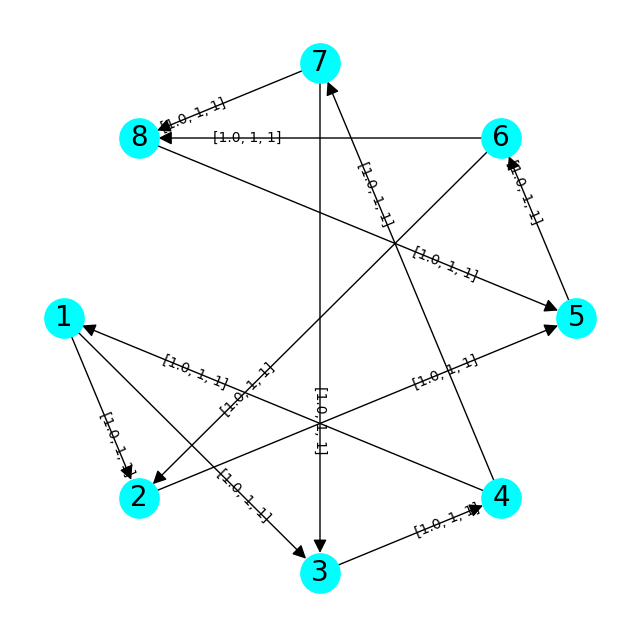

In [9]:
G = nx.DiGraph()
G.add_nodes_from(Nodes)
G.add_edges_from(Arcs)
plt.figure(figsize=(8,8))
edge_labels=nx.draw_networkx_edge_labels(G,edge_labels=CapacityCosts,
    pos=nx.shell_layout(G), label_pos=0.3, font_size=10)
nx.draw_shell(G, with_labels=True, node_color='cyan', node_size=800, 
    font_size=20, arrowsize=20)
print("Network with node labels and capacities/costs on arcs")

Network with supplies and flows for commodity  1
Network with supplies and flows for commodity  2


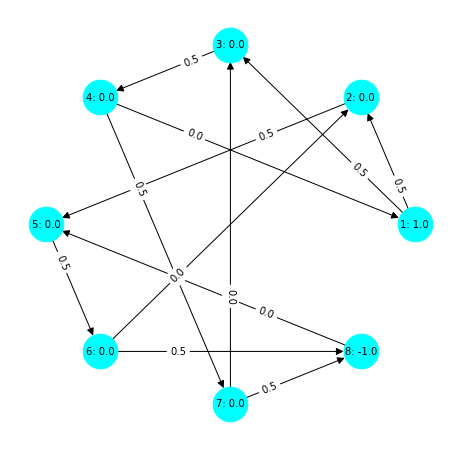

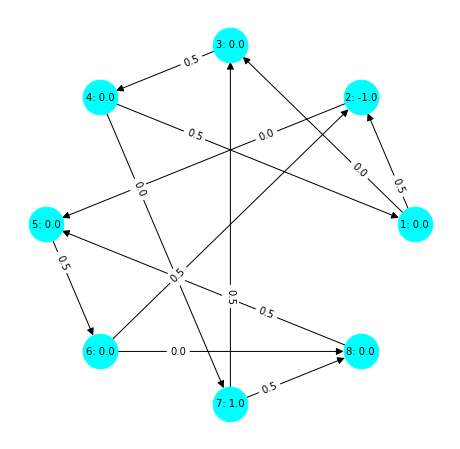

In [8]:
#k=2
for k in Commods:
    Supply1_label={}
    for i in Nodes:
        Supply1_label[i]= str(i)+': '+str(Supplies[i][k-1])

    Flow0=np.zeros(len(Arcs))
    Flow=dict(zip(list(Arcs), Flow0))
    for (i,j) in Arcs: Flow[i,j]= str(round(x[(i,j),k].X,4)) 
    H=nx.relabel_nodes(G, Supply1_label)
    plt.figure(figsize=(8,8))
    edge_labels=nx.draw_networkx_edge_labels(H,edge_labels=Flow,
        pos=nx.shell_layout(G), label_pos=0.7, font_size=10)
    nx.draw_shell(H, with_labels=True, node_color='cyan', 
         node_size=1200, font_size=10, arrowsize=15)
    print("Network with supplies and flows for commodity ",k)